# Práctico VAE (Variational AutoEncoders)

El objetivo de este práctico es explorar las Variational Autoencoders tanto en su implementación como sus bases teóricas.

In [6]:
!python -m pip install torchinfo torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 4.2 MB/s eta 0:00:004.1 MB/s eta 0:00:01


In [7]:
import torch
import torchinfo
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

### Dataset

In [8]:
# create a transofrm to apply to each datapoint
transform = transforms.ToTensor() #transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running on {DEVICE}")

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.45MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 210kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.89MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.40MB/s]

Running on mps


In [9]:
# get a batch of images
dataiter = iter(train_loader)
batch_images = next(dataiter)

In [10]:
batch_images[0].shape

torch.Size([100, 1, 28, 28])

In [11]:
# flatten batch
flatten_batch = batch_images[0].view(batch_size, 1*28*28).to(DEVICE)
flatten_batch.shape

torch.Size([100, 784])

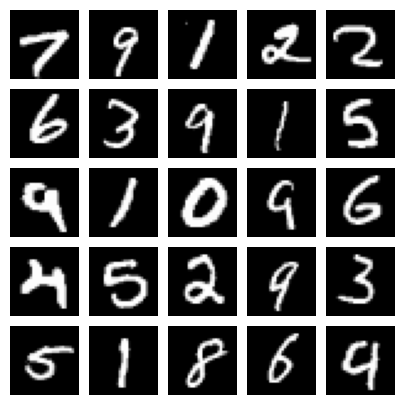

In [12]:
# get 25 sample training images for visualization
num_samples = 25
sample_images = [batch_images[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

### Modelo VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, z_dim=200, latent_dim=2, device='cpu'):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        self.device = device

        # TODO: Completar esta sección. Definir las capas de la VAE.
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        # TODO: Completar esta sección. Debes codificar 'x' usando la capa encoder
        # computar la media y la varianza de la distribución latente.
        # Devuelve la media y varianza
        ...

    def reparameterization(self, mean, var):
        # TODO: Completar esta sección. Aplica el truco de reparametrización.
        # Devuelve 'z' luego de hacer el reparametrization trick.
        ...

    def decode(self, z):
        # TODO: Completar esta sección. Usar el decodificador para transformar 'z' 
        #      de nuevo a una representación del espacio original.
        # Devuelve la reconstrucción.
        ...

    def forward(self, x):
        # TODO: Completar esta sección. Sigue el flujo de la VAE:
        # 1. Codificar
        # 2. Reparametrizar
        # 3. Decodificar
        # Devuelve la reconstrucción, la media y la varianza.
        ...
    
    def generate(self, num_samples=1):
        # TODO: Completar esta sección. Generar nuevas muestras a partir de la distribución latente.
        # Devuelve las nuevas muestras generadas.
        ...

In [ ]:
LR = ...

model = VAE(device=DEVICE).to(DEVICE)
optimizer = Adam(model.parameters(), lr=LR)

In [ ]:
torchinfo.summary(model, input_size=(100,784), col_names = ('input_size', 'output_size', 'num_params'))

###  Función de Pérdida

In [ ]:
def loss_function(x, x_hat, mean, log_var):
    # TODO: Completar esta sección. Implementar la función de pérdida de la VAE.
    # 1) Calcule la pérdida de reconstrucción (reconstruction loss) entre x y x_hat.
    reproduction_loss = ...
    # 2) Calcule la divergencia KL (Kullback-Leibler divergence) entre la distribución latente y una distribución normal estándar.
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    # 3) Devuelva la pérdida.
    return ...

### Entrenamiento

In [ ]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [ ]:
train(model.to(DEVICE), optimizer, epochs=10, device=DEVICE)

### Generación

In [ ]:
def generate_digit(z_dim=2):
    x_decoded = model.generate()
    digit = x_decoded.detach().cpu().reshape(28, 28)
    #plt.title(f'[{z_sample[0,0]},{z_sample[0,1]}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
generate_digit()

### Mostrar el espacio latente

In [ ]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(DEVICE)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

In [ ]:
plot_latent_space(model, scale=1.5)

## Ejercicios

1. Complete el código.
2. ¿Por qué es necesario el truco de reparametrización en las VAE?
3. ¿Qué representan las variables mean y var en la VAE?
4. Cree y entrene nuevas VAE modificando los hiperparámetros.
5. ¿Cómo afecta la elección del tamaño del espacio latente al rendimiento de la VAE?
6. ¿Qué rol juega el término de regularización KL-divergence en la función de pérdida de la VAE?
7. Explique que ve en la imágen que se genera cuando llamamos a la función `plot_latent_space`. Si cambiamos la dimensión del espacio latente, ¿qué pasaría con esta gráfica?